# 3. 딥러닝


## (1) 데이터 전처리

In [ ]:
# 필요 라이브러리 선언
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터 읽기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

x_org, y_org = mnist.data, mnist.target
y_org = y_org.astype(np.int) # mnist.target이 문자 배열이기 때문에 이를 정수 배열로 변환함.

In [ ]:
# 입력 데이터의 가공

# 다루기 쉽게 바꾸자
x_org = np.array(x_org)
y_org = np.array(y_org)

# step1 데이터 정규화 값의 범위를 [0, 1]로 제한
x_norm = x_org / 255.0

# 앞에 더미 데이터 변수(1)를 추가
x_all = np.insert(x_norm, 0, 1, axis=1)

print('더미 변수 추가 후', x_all.shape)

더미 변수 추가 후 (70000, 785)


In [ ]:
# step 2 y를 One-hot-Vector로
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_all_one = ohe.fit_transform(np.c_[y_org])
print('원핫 인코딩', y_all_one.shape)

원핫 인코딩 (70000, 10)


In [ ]:
# step 3 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=60000, test_size=10000, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(60000, 785) (10000, 785) (60000,) (10000,) (60000, 10) (10000, 10)


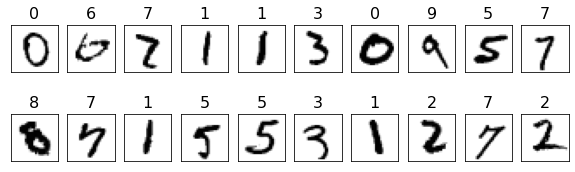

In [ ]:
# 데이터 내용 확인
N = 20
np.random.seed(123)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test[indexes, 1:]
y_selected = y_test[indexes]
plt.figure(figsize=(10, 3))
for i in range(N):
    ax = plt.subplot(2, N/2, i + 1)
    plt.imshow(x_selected[i].reshape(28, 28),cmap='gray_r')
    ax.set_title('%d' %y_selected[i], fontsize=16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## (2) 1차 학습

In [ ]:
# 시그모이드 함수
def sigmoid(x):
    return 1/(1+ np.exp(-x))

# 소프트맥스 함수
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [ ]:
# 교차 엔트로피 함수
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

# 검증 처리(리턴 값은 정확도와 손실함수)
from sklearn.metrics import accuracy_score
def evaluate(x_test, y_test, y_test_one, V, W):
    b1_test = np.insert(sigmoid(x_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(b1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss   

In [ ]:
# 미니 배치용 인덱스 취득 함수
import numpy as np

class Indexes():
    # 생성자
    def __init__(self, total, size):
        # 배열 전체의 크기
        self.total = total
        # 배치 크기
        self.size = size
        # 작업용 인덱스 초기값은 NULL로 한다.
        self.indexes = np.zeros(0)
        
    # 인덱스 취득 함수   
    def next_index(self):
        next_flag = False
        # 배치 크기보다 작업용 인덱스가 작은 경우 인덱스를 재생성
        if len(self.indexes) < self.size: 
            self.indexes = np.random.choice(self.total, 
                self.total, replace=False)
            next_flag = True
        # 복귀용 인덱스 취득과 작업용 인덱스 갱신
        index = self.indexes[:self.size]
        self.indexes = self.indexes[self.size:]
        return index, next_flag

In [ ]:
# 인덱스 클래스의 테스트

# 클래스 초기화
# 20: 전체 배열의 크기 -> 전체 데이터 수
# 5: 한번에 가져오는 인덱스 수 -> 한 번의 배치에 사용될 데이터의 수
indexes = Indexes(20, 5)

for i in range(6):
    # next_index 함수 호출
    # 리턴 값1: 인덱스의 numpy 배열
    # 리턴 값2: 작업용 인덱스가 갱신되었는지의 여부
    arr, flag = indexes.next_index()
    print(arr, flag)

[15  6 11 13 10] True
[ 7  8  2 17 14] False
[ 0 16  3 12  5] False
[ 9 19  1 18  4] False
[14  4  2 19  7] True
[18  9  1 11 15] False


In [ ]:
# 변수 초기 선언 

# 은닉층의 노드 개수
H = 128
H1 = H + 1
# M: 학습용 데이터 계열의 전체 개수
M  = x_train.shape[0]
# D: 입력 데이터의 차원 수
D = x_train.shape[1]
# N: 분류 클래스의 개수
N = y_train_one.shape[1]

# 반복 횟수
nb_epoch = 100
# 미니 배치 크기
batch_size = 512
B = batch_size
# 학습률
alpha = 0.01
# 가중치 행렬의 초기 설정(모든 값이 1)
V = np.ones((D, H))
W = np.ones((H1, N))

# 검증 결과 기록(손실함수와 정확도)
history1 = np.zeros((0, 3))
# 미니 배치를 위한 초기화
indexes = Indexes(M, batch_size)
# 반복 횟수 카운터 초기화
epoch = 0

In [ ]:
# 주요 처리
while epoch < nb_epoch:

    # 학습대상 선택(미니 배치 학습법)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]
    
    # 예측값 계산(순전파)
    a = x @ V                         # (10.6.3)
    b = sigmoid(a)                    # (10.6.4)
    b1 = np.insert(b, 0, 1, axis=1)   # 더미 변수의 추가 
    u = b1 @ W                        # (10.6.5)   
    yp = softmax(u)                   # (10.6.6)
    
    # 오차 계산
    yd = yp - yt                      # (10.6.7)
    bd = b * (1-b) * (yd @ W[1:].T)   # (10.6.8)

    # 기울기 계산
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)
    
    # 로그 기록
    if next_flag: # 1 epoch 종료 후의 처리
        score, loss = evaluate(
            x_test, y_test, y_test_one, V, W)
        history1 = np.vstack((history1, 
            np.array([epoch, loss, score])))
        print("epoch = %d     loss = %f     accuracy = %f" 
            % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0     loss = 2.302479     accuarcy = 0.102800
epoch = 1     loss = 2.301592     accuarcy = 0.113500
epoch = 2     loss = 2.302384     accuarcy = 0.102800
epoch = 3     loss = 2.301277     accuarcy = 0.113500
epoch = 4     loss = 2.302450     accuarcy = 0.113500
epoch = 5     loss = 2.301220     accuarcy = 0.113500
epoch = 6     loss = 2.301395     accuarcy = 0.113500
epoch = 7     loss = 2.301708     accuarcy = 0.113500
epoch = 8     loss = 2.301471     accuarcy = 0.113500
epoch = 9     loss = 2.301243     accuarcy = 0.113500
epoch = 10     loss = 2.301307     accuarcy = 0.113500
epoch = 11     loss = 2.301092     accuarcy = 0.113500
epoch = 12     loss = 2.302035     accuarcy = 0.098000
epoch = 13     loss = 2.301687     accuarcy = 0.113500
epoch = 14     loss = 2.301405     accuarcy = 0.113500
epoch = 15     loss = 2.301894     accuarcy = 0.113500
epoch = 16     loss = 2.301205     accuarcy = 0.113500
epoch = 17     loss = 2.301401     accuarcy = 0.113500
epoch = 18     loss 

[초기 상태] 손실함수: 2.302479, 정확도: 0.102800
[최종 상태] 손실함수: 2.301891, 정확도: 0.113500


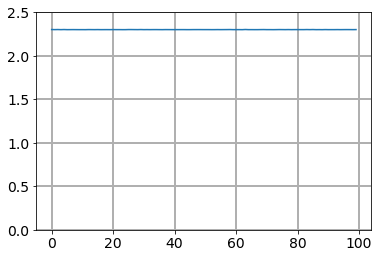

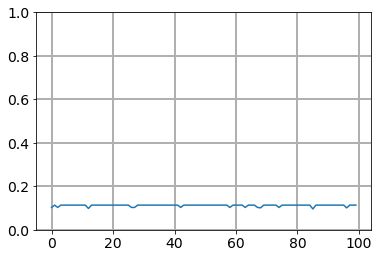

In [ ]:
#손실함수와 정확도의 확인
print('[초기 상태] 손실함수: %f, 정확도: %f'
        % (history1[0,1], history1[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
        % (history1[-1,1], history1[-1,2]))

# 학습 곡선 표시(손실함수의 값)
plt.plot(history1[:,0], history1[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

# 학습 곡선 표시(정확도)
plt.plot(history1[:,0], history1[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

## (3) 2차 학습

In [ ]:
# 변수 초기 선언 가중치 행렬의 초기화 방식 변경

# 은닉층의 노드 개수
H = 128
H1 = H + 1
# M: 학습용 데이터 계열의 전체 개수
M  = x_train.shape[0]
# D: 입력 데이터의 차원 수
D = x_train.shape[1]
# N: 분류 클래스의 개수
N = y_train_one.shape[1]

# 기계 학습 매개변수
alpha = 0.01
nb_epoch = 100
batch_size = 512
B = batch_size
# 개선된 가중치 행렬의 초기화
V = np.random.randn(D, H) / np.sqrt(D / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)
# 가중치 행렬의 초기 설정(모든 값이 1)
V = np.ones((D, H))
W = np.ones((H1, N))

# 검증 결과 기록(손실함수와 정확도)
history2 = np.zeros((0, 3))
# 미니 배치를 위한 초기화
indexes = Indexes(M, B)
# 반복 횟수 카운터 초기화
epoch = 0

print(V)
print(W)

[[ 0.01606073 -0.00589595 -0.05673273  0.04396212  0.04685946]
 [-0.0178378  -0.04058216 -0.06454661  0.00383612  0.00712562]]
[[-0.13315159 -0.05544828  0.17478607  0.02236453 -0.05550712]
 [-0.04156405  0.03331514  0.10278515  0.00901622 -0.11052494]]


In [ ]:
# 주요 처리
while epoch < nb_epoch:
    
    # 학습대상 선택(미니 배치 학습법)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 예측값 계산(순전파)
    a = x @ V                         # (10.6.3)
    b = sigmoid(a)                    # (10.6.4)
    b1 = np.insert(b, 0, 1, axis=1)   # 더미 변수의 추가
    u = b1 @ W                        # (10.6.5)
    yp = softmax(u)                   # (10.6.6)
    
    # 오차 계산
    yd = yp - yt                      # (10.6.7)
    bd = b * (1-b) * (yd @ W[1:].T)   # (10.6.8)

    # 기울기 계산
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)

    if next_flag: # 1epoch 종료 후의 처리
        score, loss = evaluate(
            x_test, y_test, y_test_one, V, W)
        history2 = np.vstack((history2, 
            np.array([epoch, loss, score])))
        print("epoch = %d      loss = %f      accuracy = %f" 
            % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0      loss = 2.475303      accuracy = 0.098200
epoch = 1      loss = 2.165526      accuracy = 0.370400
epoch = 2      loss = 2.013865      accuracy = 0.563900
epoch = 3      loss = 1.873786      accuracy = 0.652500
epoch = 4      loss = 1.742799      accuracy = 0.697200
epoch = 5      loss = 1.621452      accuracy = 0.729500
epoch = 6      loss = 1.508871      accuracy = 0.748100
epoch = 7      loss = 1.406047      accuracy = 0.764900
epoch = 8      loss = 1.312973      accuracy = 0.780500
epoch = 9      loss = 1.229245      accuracy = 0.788300
epoch = 10      loss = 1.154316      accuracy = 0.800200
epoch = 11      loss = 1.088013      accuracy = 0.807500
epoch = 12      loss = 1.029048      accuracy = 0.812600
epoch = 13      loss = 0.976628      accuracy = 0.820700
epoch = 14      loss = 0.930074      accuracy = 0.825300
epoch = 15      loss = 0.888620      accuracy = 0.830300
epoch = 16      loss = 0.851577      accuracy = 0.832500
epoch = 17      loss = 0.818268      accu

[초기 상태] 손실함수: 2.475303, 정확도: 0.098200
[최종 상태] 손실함수: 0.347259, 정확도: 0.903100




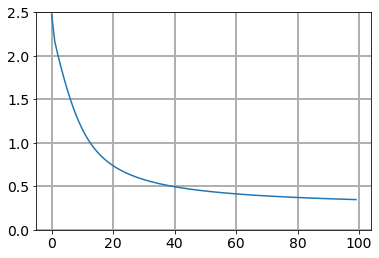

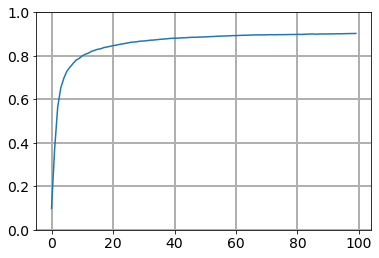

In [ ]:
# 손실함수와 정확도의 확인
print('[초기 상태] 손실함수: %f, 정확도: %f'
        % (history2[0,1], history2[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
        % (history2[-1,1], history2[-1,2]))
print('\n')

# 학습 곡선 표시(손실함수의 값)
plt.plot(history2[:,0], history2[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

# 학습 곡선 표시(정확도)
plt.plot(history2[:,0], history2[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

## (4) 3차 학습

In [ ]:
# ReLU 함수
def ReLU(x):
    return np.maximum(0, x)

# 계단함수
def step(x):
    return 1.0 * ( x > 0)

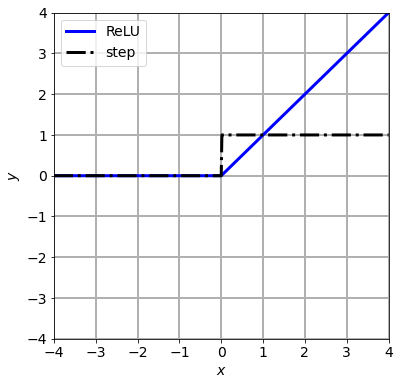

In [ ]:
# ReLU 함수와 계단함수의 그래프 표시

xx =  np.linspace(-4, 4, 501)
yy = ReLU(xx)
plt.figure(figsize=(6,6))
#plt.ylim(0.0, 1.0)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.grid(lw=2)
plt.plot(xx, ReLU(xx), c='b', label='ReLU', linestyle='-', lw=3)
plt.plot(xx, step(xx), c='k', label='step', linestyle='-.', lw=3)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# 검증 처리 (ReLU 함수 지원)
from sklearn.metrics import accuracy_score
def evaluate2(x_test, y_test, y_test_one, V, W):
    b1_test = np.insert(ReLU(x_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(b1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss   

In [ ]:
# 변수 초기 선언 가중치 행렬의 초기화 방식 변경

# 은닉층의 노드 개수
H = 128
H1 = H + 1
# M: 학습용 데이터 계열의 전체 개수
M  = x_train.shape[0]
# D: 입력 데이터의 차원 수
D = x_train.shape[1]
# N: 분류 클래스의 개수
N = y_train_one.shape[1]

# 기계 학습 매개변수
alpha = 0.01
nb_epoch = 100
batch_size = 512
B = batch_size
# 가중치 행렬의 초기 설정
V = np.random.randn(D, H) / np.sqrt(D / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 검증 결과 기록(손실함수와 정확도)
history3 = np.zeros((0, 3))
# 미니 배치를 위한 초기화
indexes = Indexes(M, batch_size)
# 반복 횟수 카운터 초기화
epoch = 0

In [ ]:
# 주요 처리 (시그모이드 함수를 ReLU 함수로 변경)
while epoch < nb_epoch:
    
    # 학습대상 선택(미니 배치 학습법)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]

    # 예측값 계산(순전파)
    a = x @ V                         # (10.6.3)
    b = ReLU(a)                       # (10.6.4) ReLU 함수로 교체
    b1 = np.insert(b, 0, 1, axis=1)   # 더미 변수의 추가 
    u = b1 @ W                        # (10.6.5)   
    yp = softmax(u)                   # (10.6.6)
    
    # 오차 계산
    yd = yp - yt                      # (10.6.7)
    bd = step(a) * (yd @ W[1:].T)     #(10.6.8) 계단함수로 교체

    # 기울기 계산
    W = W - alpha * (b1.T @ yd) / B   # (10.6.9)
    V = V - alpha * (x.T @ bd) / B    # (10.6.10)

    if next_flag: # 1epoch 종료 후의 처리
        score, loss = evaluate2(
            x_test, y_test, y_test_one, V, W)
        history3 = np.vstack((history3, 
            np.array([epoch, loss, score])))
        print("epoch = %d loss = %f score = %f" 
            % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0 loss = 2.397303 score = 0.095500
epoch = 1 loss = 1.422963 score = 0.704700
epoch = 2 loss = 0.942274 score = 0.807200
epoch = 3 loss = 0.729103 score = 0.841700
epoch = 4 loss = 0.618426 score = 0.859500
epoch = 5 loss = 0.550204 score = 0.869600
epoch = 6 loss = 0.504587 score = 0.875300
epoch = 7 loss = 0.471058 score = 0.883000
epoch = 8 loss = 0.445631 score = 0.885700
epoch = 9 loss = 0.425837 score = 0.889100
epoch = 10 loss = 0.409313 score = 0.892900
epoch = 11 loss = 0.395532 score = 0.896200
epoch = 12 loss = 0.384107 score = 0.897700
epoch = 13 loss = 0.374044 score = 0.899800
epoch = 14 loss = 0.365188 score = 0.902100
epoch = 15 loss = 0.357590 score = 0.903500
epoch = 16 loss = 0.350587 score = 0.904900
epoch = 17 loss = 0.344183 score = 0.906500
epoch = 18 loss = 0.338456 score = 0.907400
epoch = 19 loss = 0.333481 score = 0.908400
epoch = 20 loss = 0.328270 score = 0.909800
epoch = 21 loss = 0.323783 score = 0.911100
epoch = 22 loss = 0.319697 score = 0.91120

[초기 상태] 손실함수: 2.397303, 정확도: 0.095500
[최종 상태] 손실함수: 0.200852, 정확도: 0.941500




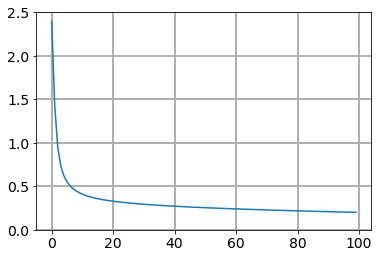

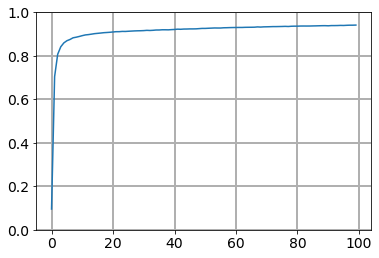

In [ ]:
# 손실함수와 정확도의 확인
print('[초기 상태] 손실함수: %f, 정확도: %f'
        % (history3[0,1], history3[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
        % (history3[-1,1], history3[-1,2]))
print('\n')

# 학습 곡선 표시(손실함수의 값)
plt.plot(history3[:,0], history3[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

# 학습 곡선 표시(정확도)
plt.plot(history3[:,0], history3[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

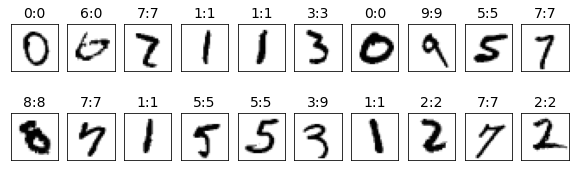

In [ ]:
# 데이터 내용 확인
import matplotlib.pyplot as plt
N = 20
np.random.seed(123)
indexes = np.random.choice(y_test.shape[0], N, replace=False)

# x_org의 선택 결과 표시(흑백 반전)
x_selected = x_test[indexes]
y_selected = y_test[indexes]

# 예측값 계산
b1_test = np.insert(ReLU(x_selected @ V), 0, 1, axis=1)
yp_test_one = softmax(b1_test @ W)
yp_test = np.argmax(yp_test_one, axis=1)

# 그래프 표시
plt.figure(figsize=(10, 3))
for i in range(N):
    ax = plt.subplot(2, N/2, i + 1)
    plt.imshow(x_selected[i,1:].reshape(28, 28),cmap='gray_r')
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]),fontsize=14 )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## (5) 4차 학습

In [ ]:
# 검증 처리 (은닉층에 2계층 지원)
from sklearn.metrics import accuracy_score
def evaluate3(x_test, y_test, y_test_one, U, V, W):
    b1_test = np.insert(ReLU(x_test @ U), 0, 1, axis=1)
    d1_test = np.insert(ReLU(b1_test @ V), 0, 1, axis=1)
    yp_test_one = softmax(d1_test @ W)
    yp_test = np.argmax(yp_test_one, axis=1)
    loss = cross_entropy(y_test_one, yp_test_one)
    score = accuracy_score(y_test, yp_test)
    return score, loss   

In [ ]:
# 변수 초기 선언 가중치 행렬의 초기화 방식 변경

# 은닉층의 노드 개수
H = 128
H1 = H + 1
# M: 학습용 데이터 계열의 전체 개수
M  = x_train.shape[0]
# D: 입력 데이터의 차원 수
D = x_train.shape[1]
# N: 분류 클래스의 개수
N = y_train_one.shape[1]

# 기계 학습 매개변수
alpha = 0.01
nb_epoch = 200
batch_size = 512
B = batch_size
# 가중치 행렬의 초기 설정
U = np.random.randn(D, H) / np.sqrt(D / 2)
V = np.random.randn(H1, H) / np.sqrt(H1 / 2)
W = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 검증 결과 기록(손실함수와 정확도)
history4 = np.zeros((0, 3))
# 미니 배치를 위한 초기화
indexes = Indexes(M, batch_size)
# 반복 횟수 카운터 초기화
epoch = 0

In [ ]:
# 주요 처리 (은닉층 2계층화)
while epoch < nb_epoch:
    # 학습대상 선택(미니 배치 학습법)
    index, next_flag = indexes.next_index()
    x, yt = x_train[index], y_train_one[index]
    
    # 예측값 계산(순전파)
    a = x @ U                        # (10.6.11)
    b = ReLU(a)                      # (10.6.12)
    b1 = np.insert(b, 0, 1, axis=1)  # 더미 변수의 추가
    c = b1 @ V                       # (10.6.13)
    d = ReLU(c)                      # (10.6.14)
    d1 = np.insert(d, 0, 1, axis=1)  # 더미 변수의 추가
    u = d1 @ W                       # (10.6.15)
    yp = softmax(u)                  # (10.6.16)
    
    # 오차 계산
    yd = yp - yt                     # (10.6.17)
    dd = step(c) * (yd @ W[1:].T)    # (10.6.18)
    bd = step(a) * (dd @ V[1:].T)    # (10.6.19)

    # 기울기 계산
    W = W - alpha * (d1.T @ yd) / B  # (10.6.20)
    V = V - alpha * (b1.T @ dd) / B  # (10.6.21)
    U = U - alpha * (x.T @ bd) / B   # (10.6.22)

    if next_flag: # 1epoch 종료 후의 처리
        score, loss = evaluate3(
            x_test, y_test, y_test_one, U, V, W)
        history4 = np.vstack((history4, 
            np.array([epoch, loss, score])))
        print("epoch = %d      loss = %f      accuracy = %f" 
            % (epoch, loss, score))
        epoch = epoch + 1

epoch = 0      loss = 2.384611      accuracy = 0.112800
epoch = 1      loss = 1.408489      accuracy = 0.697000
epoch = 2      loss = 0.851626      accuracy = 0.810400
epoch = 3      loss = 0.629785      accuracy = 0.845900
epoch = 4      loss = 0.525465      accuracy = 0.867200
epoch = 5      loss = 0.464634      accuracy = 0.879400
epoch = 6      loss = 0.424851      accuracy = 0.888900
epoch = 7      loss = 0.395783      accuracy = 0.894200
epoch = 8      loss = 0.374510      accuracy = 0.899200
epoch = 9      loss = 0.357640      accuracy = 0.903200
epoch = 10      loss = 0.343602      accuracy = 0.906800
epoch = 11      loss = 0.332329      accuracy = 0.909500
epoch = 12      loss = 0.322984      accuracy = 0.911700
epoch = 13      loss = 0.314158      accuracy = 0.914000
epoch = 14      loss = 0.306151      accuracy = 0.915400
epoch = 15      loss = 0.299058      accuracy = 0.917700
epoch = 16      loss = 0.293303      accuracy = 0.919500
epoch = 17      loss = 0.288032      accu

[초기 상태] 손실함수: 1.408489, 정확도: 0.697000
[최종 상태] 손실함수: 0.098049, 정확도: 0.970900




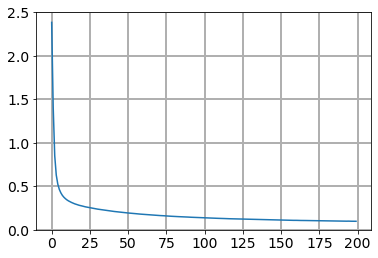

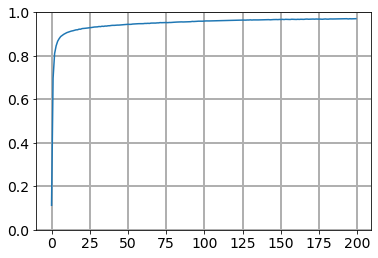

In [ ]:
# 손실함수와 정확도의 확인
print('[초기 상태] 손실함수: %f, 정확도: %f'
    % (history4[1,1], history4[1,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
    % (history4[-1,1], history4[-1,2]))
print('\n')

# 학습 곡선 표시(손실함수의 값)
plt.plot(history4[:,0], history4[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

# 학습 곡선 표시(정확도)
plt.plot(history4[:,0], history4[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

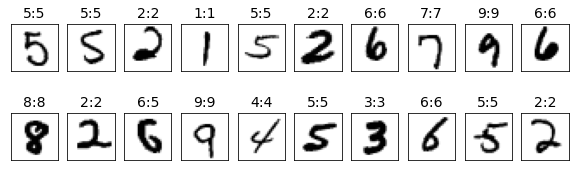

In [ ]:
# 데이터 내용 확인
import matplotlib.pyplot as plt
N = 20
np.random.seed(111)
indexes = np.random.choice(y_test.shape[0], N, replace=False)

# x_org의 선택 결과 표시(흑백 반전)
x_selected = x_test[indexes]
y_selected = y_test[indexes]

# 예측값 계산
b1_test = np.insert(ReLU(x_selected @ U), 0, 1, axis=1)
d1_test = np.insert(ReLU(b1_test @ V), 0, 1, axis=1)
yp_test_one = softmax(d1_test @ W)
yp_test = np.argmax(yp_test_one, axis=1)

# 그래프 표시
plt.figure(figsize=(10, 3))
for i in range(N):
    ax = plt.subplot(2, N/2, i + 1)
    plt.imshow(x_selected[i,1:].reshape(28, 28),cmap='gray_r')
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]),fontsize=14 )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()